<a href="https://www.kaggle.com/code/aritra423/drawing-with-llm-pali-gemma-2?scriptVersionId=240219778" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Suppresses INFO and WARNING logs


Kaagle Metric


In [2]:
import ast
import io
import math
import statistics
import string
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
import cairosvg
import clip
import torch
import torch.nn as nn
import cv2
from more_itertools import chunked

import kagglehub
svg_constraints = kagglehub.package_import('metric/svg-constraints')

class ParticipantVisibleError(Exception):
    pass

def score(
    solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, random_seed: int = 0
) -> float:
    for colname in ['question', 'choices', 'answer']:
        solution[colname] = solution[colname].apply(ast.literal_eval)
    solution = solution.explode(['question', 'choices', 'answer'])

    if not pd.api.types.is_string_dtype(submission.loc[:, 'svg']):
        raise ParticipantVisibleError('svg must be a string.')

    constraints = svg_constraints.SVGConstraints()
    try:
        for svg in submission.loc[:, 'svg']:
            constraints.validate_svg(svg)
    except Exception:
        raise ParticipantVisibleError('SVG code violates constraints.')

    vqa_evaluator = VQAEvaluator()
    aesthetic_evaluator = AestheticEvaluator()

    results = []
    rng = np.random.RandomState(random_seed)
    try:
        df = solution.merge(submission, on='id')
        for i, (_, group) in enumerate(df.loc[
            :, ['id', 'question', 'choices', 'answer', 'svg']
        ].groupby('id')):
            questions, choices, answers, svg = [
                group[col_name].to_list()
                for col_name in group.drop('id', axis=1).columns
            ]
            svg = svg[0]
            group_seed = rng.randint(0, np.iinfo(np.int32).max)
            image_processor = ImageProcessor(image=svg_to_png(svg), seed=group_seed).apply()
            image = image_processor.image.copy()
            aesthetic_score = aesthetic_evaluator.score(image)
            vqa_score = vqa_evaluator.score(questions, choices, answers, image)
            image_processor.reset().apply_random_crop_resize().apply_jpeg_compression(quality=90)
            ocr_score = vqa_evaluator.ocr(image_processor.image)
            instance_score = (
                harmonic_mean(vqa_score, aesthetic_score, beta=0.5) * ocr_score
            )
            results.append(instance_score)
    except Exception:
        raise ParticipantVisibleError('SVG failed to score.')

    fidelity = statistics.mean(results)
    return float(fidelity)

class VQAEvaluator:
    def __init__(self):
        from transformers import (
            AutoProcessor,
            BitsAndBytesConfig,
            PaliGemmaForConditionalGeneration,
        )
        self.quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type='nf4',
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.float16,
        )
        self.letters = string.ascii_uppercase
        self.model_path = kagglehub.model_download(
            'google/paligemma-2/transformers/paligemma2-10b-mix-448'
        )
        self.processor = AutoProcessor.from_pretrained(self.model_path)
        self.model = PaliGemmaForConditionalGeneration.from_pretrained(
            self.model_path,
            low_cpu_mem_usage=True,
            quantization_config=self.quantization_config,
        ).to('cuda:0')

    def score(self, questions, choices, answers, image, n=4):
        scores = []
        batches = (chunked(qs, n) for qs in [questions, choices, answers])
        for question_batch, choice_batch, answer_batch in zip(*batches, strict=True):
            scores.extend(
                self.score_batch(
                    image,
                    question_batch,
                    choice_batch,
                    answer_batch,
                )
            )
        return statistics.mean(scores)

    def score_batch(
        self,
        image: Image.Image,
        questions: list[str],
        choices_list: list[list[str]],
        answers: list[str],
    ) -> list[float]:
        prompts = [
            self.format_prompt(question, choices)
            for question, choices in zip(questions, choices_list, strict=True)
        ]
        batched_choice_probabilities = self.get_choice_probability(
            image, prompts, choices_list
        )

        scores = []
        for i, _ in enumerate(questions):
            choice_probabilities = batched_choice_probabilities[i]
            answer = answers[i]
            answer_probability = 0.0
            for choice, prob in choice_probabilities.items():
                if choice == answer:
                    answer_probability = prob
                    break
            scores.append(answer_probability)

        return scores

    def format_prompt(self, question: str, choices: list[str]) -> str:
        prompt = f'<image>answer en Question: {question}\nChoices:\n'
        for i, choice in enumerate(choices):
            prompt += f'{self.letters[i]}. {choice}\n'
        return prompt

    def mask_choices(self, logits, choices_list):
        batch_size = logits.shape[0]
        masked_logits = torch.full_like(logits, float('-inf'))

        for batch_idx in range(batch_size):
            choices = choices_list[batch_idx]
            for i in range(len(choices)):
                letter_token = self.letters[i]
                first_token = self.processor.tokenizer.encode(
                    letter_token, add_special_tokens=False
                )[0]
                first_token_with_space = self.processor.tokenizer.encode(
                    ' ' + letter_token, add_special_tokens=False
                )[0]

                if isinstance(first_token, int):
                    masked_logits[batch_idx, first_token] = logits[
                        batch_idx, first_token
                    ]
                if isinstance(first_token_with_space, int):
                    masked_logits[batch_idx, first_token_with_space] = logits[
                        batch_idx, first_token_with_space
                    ]

        return masked_logits

    def get_choice_probability(self, image, prompts, choices_list) -> list[dict]:
        inputs = self.processor(
            images=[image] * len(prompts),
            text=prompts,
            return_tensors='pt',
            padding='longest',
        ).to('cuda:0')

        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits[:, -1, :]
            masked_logits = self.mask_choices(logits, choices_list)
            probabilities = torch.softmax(masked_logits, dim=-1)

        batched_choice_probabilities = []
        for batch_idx in range(len(prompts)):
            choice_probabilities = {}
            choices = choices_list[batch_idx]
            for i, choice in enumerate(choices):
                letter_token = self.letters[i]
                first_token = self.processor.tokenizer.encode(
                    letter_token, add_special_tokens=False
                )[0]
                first_token_with_space = self.processor.tokenizer.encode(
                    ' ' + letter_token, add_special_tokens=False
                )[0]

                prob = 0.0
                if isinstance(first_token, int):
                    prob += probabilities[batch_idx, first_token].item()
                if isinstance(first_token_with_space, int):
                    prob += probabilities[batch_idx, first_token_with_space].item()
                choice_probabilities[choice] = prob

            total_prob = sum(choice_probabilities.values())
            if total_prob > 0:
                renormalized_probabilities = {
                    choice: prob / total_prob
                    for choice, prob in choice_probabilities.items()
                }
            else:
                renormalized_probabilities = choice_probabilities
            batched_choice_probabilities.append(renormalized_probabilities)

        return batched_choice_probabilities

    def ocr(self, image, free_chars=4):
        inputs = (
            self.processor(
                text='<image>ocr\n',
                images=image,
                return_tensors='pt',
            )
            .to(torch.float16)
            .to(self.model.device)
        )
        input_len = inputs['input_ids'].shape[-1]

        with torch.inference_mode():
            outputs = self.model.generate(**inputs, max_new_tokens=32, do_sample=False)
            outputs = outputs[0][input_len:]
            decoded = self.processor.decode(outputs, skip_special_tokens=True)

        num_char = len(decoded)
        return min(1.0, math.exp(-num_char + free_chars))

class AestheticPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.layers(x)

class AestheticEvaluator:
    def __init__(self):
        self.model_path = '/kaggle/input/sac-logos-ava1-l14-linearmse/sac+logos+ava1-l14-linearMSE.pth'
        self.clip_model_path = '/kaggle/input/openai-clip-vit-large-patch14/ViT-L-14.pt'
        self.predictor, self.clip_model, self.preprocessor = self.load()

    def load(self):
        state_dict = torch.load(self.model_path, weights_only=True, map_location='cuda:1')
        predictor = AestheticPredictor(768)
        predictor.load_state_dict(state_dict)
        predictor.to('cuda:1')
        predictor.eval()
        clip_model, preprocessor = clip.load(self.clip_model_path, device='cuda:1')
        return predictor, clip_model, preprocessor

    def score(self, image: Image.Image) -> float:
        image = self.preprocessor(image).unsqueeze(0).to('cuda:1')
        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            image_features = image_features.cpu().detach().numpy()
        score = self.predictor(torch.from_numpy(image_features).to('cuda:1').float())
        return score.item() / 10.0

def harmonic_mean(a: float, b: float, beta: float = 1.0) -> float:
    if a <= 0 or b <= 0:
        return 0.0
    return (1 + beta**2) * (a * b) / (beta**2 * a + b)

def svg_to_png(svg_code: str, size: tuple = (384, 384)) -> Image.Image:
    if 'viewBox' not in svg_code:
        svg_code = svg_code.replace('<svg', f'<svg viewBox="0 0 {size[0]} {size[1]}"')
    png_data = cairosvg.svg2png(bytestring=svg_code.encode('utf-8'))
    return Image.open(io.BytesIO(png_data)).convert('RGB').resize(size)

class ImageProcessor:
    def __init__(self, image: Image.Image, seed=None):
        self.image = image
        self.original_image = self.image.copy()
        if seed is not None:
            self.rng = np.random.RandomState(seed)
        else:
            self.rng = np.random

    def reset(self):
        self.image = self.original_image.copy()
        return self

    def apply_median_filter(self, size=3):
        self.image = self.image.filter(ImageFilter.MedianFilter(size=size))
        return self

    def apply_bilateral_filter(self, d=9, sigma_color=75, sigma_space=75):
        img_array = np.asarray(self.image)
        filtered = cv2.bilateralFilter(img_array, d, sigma_color, sigma_space)
        self.image = Image.fromarray(filtered)
        return self

    def apply_fft_low_pass(self, cutoff_frequency=0.5):
        img_array = np.array(self.image, dtype=np.float32)
        result = np.zeros_like(img_array)
        for i in range(3):
            f = np.fft.fft2(img_array[:, :, i])
            fshift = np.fft.fftshift(f)
            rows, cols = img_array[:, :, i].shape
            crow, ccol = rows // 2, cols // 2
            mask = np.zeros((rows, cols), np.float32)
            r = int(min(crow, ccol) * cutoff_frequency)
            center = [crow, ccol]
            x, y = np.ogrid[:rows, :cols]
            mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r * r
            mask[mask_area] = 1
            fshift_filtered = fshift * mask
            f_ishift = np.fft.ifftshift(fshift_filtered)
            img_back = np.fft.ifft2(f_ishift)
            img_back = np.real(img_back)
            result[:, :, i] = img_back
        result = np.clip(result, 0, 255).astype(np.uint8)
        self.image = Image.fromarray(result)
        return self

    def apply_jpeg_compression(self, quality=85):
        buffer = io.BytesIO()
        self.image.save(buffer, format='JPEG', quality=quality)
        buffer.seek(0)
        self.image = Image.open(buffer)
        return self

    def apply_random_crop_resize(self, crop_percent=0.05):
        width, height = self.image.size
        crop_pixels_w = int(width * crop_percent)
        crop_pixels_h = int(height * crop_percent)
        left = self.rng.randint(0, crop_pixels_w + 1)
        top = self.rng.randint(0, crop_pixels_h + 1)
        right = width - self.rng.randint(0, crop_pixels_w + 1)
        bottom = height - self.rng.randint(0, crop_pixels_h + 1)
        self.image = self.image.crop((left, top, right, bottom))
        self.image = self.image.resize((width, height), Image.BILINEAR)
        return self

    def apply(self):
        return (
            self.apply_random_crop_resize(crop_percent=0.03)
            .apply_jpeg_compression(quality=95)
            .apply_median_filter(size=9)
            .apply_fft_low_pass(cutoff_frequency=0.5)
            .apply_bilateral_filter(d=5, sigma_color=75, sigma_space=75)
            .apply_jpeg_compression(quality=92)
        )

In [3]:
import torch
from transformers import AutoProcessor, BitsAndBytesConfig, PaliGemmaForConditionalGeneration
import kagglehub
import os

print("Using device:", "cuda" if torch.cuda.is_available() else "cpu")

# Print the installed transformers version
import transformers
print(f"Transformers version: {transformers.__version__}")

# Download model files
model_path = kagglehub.model_download('google/paligemma-2/transformers/paligemma2-10b-mix-448')
print(f"Model path: {model_path}")
print(f"Files in model directory: {os.listdir(model_path)}")

# Try finding spiece.model, tokenizer.model or similar files
model_files = []
for root, dirs, files in os.walk(os.path.dirname(model_path)):
    for file in files:
        if file.endswith('.model'):
            model_files.append(os.path.join(root, file))
print(f"Model files found: {model_files}")

# Configure quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

# Try loading directly with the model path
try:
    print("Attempting to load model directly...")
    model = PaliGemmaForConditionalGeneration.from_pretrained(
        model_path,
        quantization_config=quantization_config,
        torch_dtype=torch.float16,
        low_cpu_mem_usage=True,
        device_map="auto",
    )
    print("Model loaded successfully!")
    
    # Try loading processor directly
    try:
        processor = AutoProcessor.from_pretrained(model_path)
        print("Processor loaded successfully!")
    except Exception as e:
        print(f"Error loading processor: {e}")
        # If that fails, try a different approach (using your earlier working code)
        from transformers import PreTrainedTokenizerFast
        tokenizer = PreTrainedTokenizerFast(tokenizer_file=os.path.join(model_path, "tokenizer.json"))
        print("Loaded tokenizer using PreTrainedTokenizerFast")
        
except Exception as e:
    print(f"Error loading model: {e}")
    print("Attempting alternative loading method...")

print("PaLiGemma 2 loading process complete.")

2025-05-17 08:48:53.603290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747471733.627272     131 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747471733.634297     131 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda
Transformers version: 4.51.3
Model path: /kaggle/input/paligemma-2/transformers/paligemma2-10b-mix-448/1
Files in model directory: ['model.safetensors.index.json', 'model-00003-of-00004.safetensors', 'config.json', 'preprocessor_config.json', 'model-00001-of-00004.safetensors', 'tokenizer.json', 'tokenizer_config.json', 'model-00004-of-00004.safetensors', 'special_tokens_map.json', 'model-00002-of-00004.safetensors', 'generation_config.json']
Model files found: []
Attempting to load model directly...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Model loaded successfully!
Processor loaded successfully!
PaLiGemma 2 loading process complete.


In [4]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
pipe = pipe.to("cuda")  # Or "cpu" if you don't have a GPU

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
import numpy as np
import cv2
from PIL import Image
from skimage.segmentation import slic
from skimage.measure import regionprops, label
from skimage.color import rgb2lab, rgb2gray
from skimage.filters import sobel

def compress_hex_color(hex_color):
    r, g, b = int(hex_color[1:3], 16), int(hex_color[3:5], 16), int(hex_color[5:7], 16)
    if r % 17 == 0 and g % 17 == 0 and b % 17 == 0:
        return f'#{r//17:x}{g//17:x}{b//17:x}'
    return hex_color

def fit_polygon(contour, max_error=2.0):
    """Fit a polygon to the given contour using the Ramer-Douglas-Peucker algorithm."""
    epsilon = max_error
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return approx

def fit_ellipse(contour):
    """Fit an ellipse to the given contour if possible."""
    if len(contour) < 5:
        return None
    ellipse = cv2.fitEllipse(contour)
    return ellipse

def color_contrast(color1, color2):
    # Use Euclidean distance in LAB color space for perceptual contrast
    l1 = rgb2lab(np.array([[color1]], dtype=np.uint8)/255.0)[0,0]
    l2 = rgb2lab(np.array([[color2]], dtype=np.uint8)/255.0)[0,0]
    return np.linalg.norm(l1 - l2)

def extract_advanced_features(img_np, max_superpixels=200, num_colors=16):
    """Multi-scale segmentation, edge detection, and saliency-weighted feature extraction."""
    # Ensure RGB
    if img_np.shape[2] == 4:
        img_np = img_np[:,:,:3]
    img_rgb = img_np if img_np.shape[2] == 3 else cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)
    
    height, width = img_rgb.shape[:2]
    img_lab = rgb2lab(img_rgb/255.0)
    img_gray = rgb2gray(img_rgb)
    edge_map = sobel(img_gray)
    # SLIC superpixel segmentation for multi-scale features
    segments = slic(img_rgb, n_segments=max_superpixels, compactness=10, start_label=1)
    region_labels = label(segments)
    regions = regionprops(region_labels)
    
    # K-means color quantization
    pixels = img_rgb.reshape(-1, 3).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, num_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    palette = centers.astype(np.uint8)
    quantized = palette[labels.flatten()].reshape(img_rgb.shape)
    
    # Saliency: edge strength, area, color contrast, and spatial centrality
    center_x, center_y = width/2, height/2
    features = []
    
    for region in regions:
        minr, minc, maxr, maxc = region.bbox
        mask = (region_labels == region.label).astype(np.uint8)
        contour_list, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contour_list) == 0:
            continue
        contour = max(contour_list, key=cv2.contourArea)
        area = cv2.contourArea(contour)
        if area < 30:
            continue
        # Dominant color in this region (mode of quantized image in region)
        region_pixels = quantized[mask.astype(bool)]
        if len(region_pixels) == 0:
            continue
        unique, counts = np.unique(region_pixels.reshape(-1,3), axis=0, return_counts=True)
        dom_color = unique[counts.argmax()]
        hex_color = compress_hex_color(f'#{dom_color[0]:02x}{dom_color[1]:02x}{dom_color[2]:02x}')
        
        # Fit a polygon (could also try ellipse or Bezier)
        poly = fit_polygon(contour, max_error=3.0)
        if len(poly) < 3:
            continue
        points = " ".join([f"{pt[0][0]:.2f},{pt[0][1]:.2f}" for pt in poly])
        
        # Optionally fit ellipse if region is roughly elliptical
        ellipse_svg = ""
        ellipse = fit_ellipse(contour)
        if ellipse is not None and area / (np.pi * ellipse[1][0]/2 * ellipse[1][1]/2) > 0.85:
            (cx, cy), (maj, min), angle = ellipse
            ellipse_svg = f'<ellipse cx="{cx:.2f}" cy="{cy:.2f}" rx="{maj/2:.2f}" ry="{min/2:.2f}" fill="{hex_color}" transform="rotate({angle:.1f} {cx:.2f} {cy:.2f})"/>'
        
        # Importance: area, edge saliency, color contrast to mean bg, centrality
        m = cv2.moments(contour)
        cx = int(m["m10"] / m["m00"]) if m["m00"] > 0 else (minc+maxc)/2
        cy = int(m["m01"] / m["m00"]) if m["m00"] > 0 else (minr+maxr)/2
        dist_from_center = np.sqrt(((cx - center_x) / width)**2 + ((cy - center_y) / height)**2)
        mean_edge = np.mean(edge_map[mask.astype(bool)])
        bg_color = np.mean(img_rgb, axis=(0,1)).astype(int)
        contrast = color_contrast(dom_color, bg_color)
        importance = (area * (1 - dist_from_center) * (mean_edge + 0.2) * (contrast+5))
        features.append({
            'points': points,
            'color': hex_color,
            'area': area,
            'importance': importance,
            'ellipse_svg': ellipse_svg
        })
    features.sort(key=lambda x: x['importance'], reverse=True)
    return features

def advanced_bitmap_to_svg(
    image,
    max_size_bytes=20000,
    resize=True,
    target_size=(384, 384),
    max_superpixels=200,
    num_colors=16,
    use_ellipses=True,
    group_similar=True,
):
    """
    Convert a bitmap PIL image to an advanced, high-fidelity SVG string.
    """
    if resize:
        original_size = image.size
        image = image.resize(target_size, Image.LANCZOS)
    else:
        original_size = image.size
    img_np = np.array(image)
    height, width = img_np.shape[:2]
    avg_bg_color = np.mean(img_np[:,:,:3], axis=(0,1)).astype(int) if img_np.shape[2] >= 3 else 255
    bg_hex_color = compress_hex_color(f'#{avg_bg_color[0]:02x}{avg_bg_color[1]:02x}{avg_bg_color[2]:02x}')
    orig_width, orig_height = original_size
    svg = [f'<svg xmlns="http://www.w3.org/2000/svg" width="{orig_width}" height="{orig_height}" viewBox="0 0 {width} {height}">']
    svg.append(f'<rect width="{width}" height="{height}" fill="{bg_hex_color}"/>')
    features = extract_advanced_features(
        img_np,
        max_superpixels=max_superpixels,
        num_colors=num_colors
    )
    # Optionally group polygons by color for smaller SVG
    if group_similar:
        from collections import defaultdict
        color_groups = defaultdict(list)
        for f in features:
            color_groups[f['color']].append(f)
        for color, feats in sorted(color_groups.items(), key=lambda x: -sum(f['importance'] for f in x[1])):
            svg.append(f'<g fill="{color}">')
            for feat in feats:
                if use_ellipses and feat['ellipse_svg']:
                    svg.append(feat['ellipse_svg'])
                svg.append(f'<polygon points="{feat["points"]}"/>')
            svg.append('</g>')
    else:
        for feat in features:
            if use_ellipses and feat['ellipse_svg']:
                svg.append(feat['ellipse_svg'])
            svg.append(f'<polygon points="{feat["points"]}" fill="{feat["color"]}"/>')
    svg.append('</svg>')
    svg_str = "".join(svg)
    # Truncate if needed
    if len(svg_str.encode('utf-8')) > max_size_bytes:
        svg_str = f'<svg xmlns="http://www.w3.org/2000/svg" width="{orig_width}" height="{orig_height}" viewBox="0 0 {width} {height}"><rect width="{width}" height="{height}" fill="{bg_hex_color}"/></svg>'
    return svg_str

In [7]:
#| export

def generate_bitmap_advanced(
    prompt,
    negative_prompt="",
    num_inference_steps=20,
    guidance_scale=15,
    pipe=None,
    device=None,
    verbose=False,
    seed=None,
    **extra_kwargs
):
    """
    Generate an image using a diffusion pipeline with advanced options.
    
    Parameters:
        prompt (str): The prompt for image generation.
        negative_prompt (str): Features to avoid.
        num_inference_steps (int): Number of diffusion steps.
        guidance_scale (float): Classifier-free guidance scale.
        pipe: Diffusion pipeline object (if None, uses global 'pipe').
        device: Device for inference (if not None, moves pipe to device).
        verbose (bool): If True, prints diagnostic information.
        seed (int or None): Optional random seed for reproducibility.
        extra_kwargs: Any additional keyword arguments for the pipeline.
        
    Returns:
        image: The generated image (PIL.Image or similar).
    """
    import torch

    if pipe is None:
        try:
            pipe = globals()["pipe"]
        except KeyError:
            raise ValueError("No 'pipe' diffusion pipeline provided or defined globally.")

    if device is not None:
        pipe = pipe.to(device)
        if verbose:
            print(f"Pipeline moved to device: {device}")

    generator = None
    if seed is not None:
        generator = torch.Generator(device=device if device else "cpu").manual_seed(seed)
        if verbose:
            print(f"Using random seed: {seed}")

    if verbose:
        print(f"Prompt: {prompt}")
        print(f"Negative prompt: {negative_prompt}")
        print(f"Inference steps: {num_inference_steps}")
        print(f"Guidance scale: {guidance_scale}")

    result = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=generator,
        **extra_kwargs
    )
    image = result.images[0]
    if verbose:
        print("Image generated successfully.")
    return image

In [8]:
import threading

# Global model objects for single initialization (thread-safe)
_global_vqa_evaluator = None
_global_aesthetic_evaluator = None
_evaluator_lock = threading.Lock()

def initialize_evaluators():
    """Thread-safe, initialize and cache evaluators."""
    global _global_vqa_evaluator, _global_aesthetic_evaluator
    with _evaluator_lock:
        if _global_vqa_evaluator is None:
            print("[Evaluator] Initializing VQA Evaluator...")
            _global_vqa_evaluator = VQAEvaluator()
        if _global_aesthetic_evaluator is None:
            print("[Evaluator] Initializing Aesthetic Evaluator...")
            _global_aesthetic_evaluator = AestheticEvaluator()
    return _global_vqa_evaluator, _global_aesthetic_evaluator

def evaluate_svg(svg: str, prompt: str, 
                 vqa_weight: float = 2.0, 
                 cache: dict = None, 
                 complexity_alpha: float = 0.015,
                 verbose: bool = False) -> dict:
    """
    Evaluate SVG illustration quality for a competition:
      - VQA (semantic relevance to prompt)
      - Aesthetics (CLIP-based)
      - SVG complexity penalty (optional)
    Returns a dict of scores.
    """
    cache_key = (svg, prompt)
    if cache is not None and cache_key in cache:
        return cache[cache_key]

    vqa_evaluator, aesthetic_evaluator = initialize_evaluators()
    image = svg_to_png(svg)
    
    vqa_prompt = f"SVG illustration of {prompt}"
    vqa_score = vqa_evaluator.score(image, vqa_prompt)
    aesthetic_score = aesthetic_evaluator.score(image)
    complexity_penalty = svg_complexity_penalty(svg, alpha=complexity_alpha)

    combined_score = harmonic_mean(vqa_score, aesthetic_score, beta=vqa_weight) * complexity_penalty

    result = {
        'vqa_score': vqa_score,
        'aesthetic_score': aesthetic_score,
        'complexity_penalty': complexity_penalty,
        'combined_score': combined_score
    }
    if cache is not None:
        cache[cache_key] = result
    if verbose:
        print(f"[Evaluator] Prompt: {prompt}\n"
              f"  VQA: {vqa_score:.3f}, Aesthetic: {aesthetic_score:.3f}, "
              f"Complexity Penalty: {complexity_penalty:.3f}, "
              f"Combined: {combined_score:.3f}")
    return result

def svg_complexity_penalty(svg_code: str, alpha: float = 0.015) -> float:
    """
    Penalize SVGs with high command count to encourage simplicity.
    """
    import re
    num_commands = len(re.findall(r'([MLCQZmlcqz])', svg_code))
    return float(np.exp(-alpha * num_commands))

In [9]:
default_svgs = [
    # Advanced geometric + abstract SVG
    '''
    <svg xmlns="http://www.w3.org/2000/svg" width="384" height="384">
      <rect width="100%" height="100%" fill="#f5f5f5"/>
      <g stroke="#262626" stroke-width="2">
        <rect x="40" y="40" width="304" height="304" rx="32" fill="#e0eafc"/>
        <circle cx="192" cy="192" r="108" fill="#aad8d3" stroke="#2e3440" stroke-width="8"/>
        <polygon points="192,70 250,314 134,314" fill="#ef476f" opacity="0.85" stroke="#2e3440" stroke-width="2"/>
        <polyline points="96,160 288,160 192,320 96,160" fill="none" stroke="#0077b6" stroke-width="6" opacity="0.7"/>
        <path d="M130 110 Q192 40 254 110 T254 274 Q192 344 130 274 T130 110" fill="none" stroke="#ff006e" stroke-width="4" opacity="0.8"/>
      </g>
      <g fill="none" stroke-linecap="round" stroke-linejoin="round">
        <path stroke="#FF4700" stroke-width="13" d="M160 220q140-10 55-93"/>
        <path stroke="#FF5E00" stroke-width="6" d="M88 83q-14 90 170 74"/>
        <path stroke="#FDA1F6" stroke-opacity=".5" stroke-width="11" d="M280 175q23 27-200 100"/>
        <path stroke="#C77145" stroke-opacity=".7" stroke-width="19" d="M133 256q132 0 120-87"/>
      </g>
    </svg>
    ''',

    # Layered SVG with ellipses and gradients
    '''
    <svg xmlns="http://www.w3.org/2000/svg" width="384" height="384">
      <defs>
        <radialGradient id="bg" cx="50%" cy="50%" r="65%">
          <stop offset="0%" stop-color="#fffbe7"/>
          <stop offset="100%" stop-color="#dbeafe"/>
        </radialGradient>
      </defs>
      <rect width="384" height="384" fill="url(#bg)"/>
      <ellipse cx="192" cy="192" rx="140" ry="80" fill="#a3be8c" fill-opacity="0.7"/>
      <ellipse cx="120" cy="192" rx="60" ry="140" fill="#5e81ac" fill-opacity="0.6"/>
      <ellipse cx="264" cy="192" rx="60" ry="140" fill="#bf616a" fill-opacity="0.5"/>
      <circle cx="192" cy="192" r="48" fill="#ebcb8b"/>
      <g stroke="#495867" stroke-width="4" fill="none">
        <path d="M140 120 Q192 40 244 120"/>
        <path d="M244 264 Q192 344 140 264"/>
        <path d="M80 192 Q192 80 304 192"/>
        <path d="M304 192 Q192 304 80 192"/>
      </g>
    </svg>
    ''',

    # Abstract paths and corners
    '''
    <svg xmlns="http://www.w3.org/2000/svg" width="384" height="384">
      <rect width="384" height="384" fill="#fafafa"/>
      <rect x="0" y="0" width="384" height="48" fill="#b4c9e7"/>
      <rect x="0" y="336" width="384" height="48" fill="#b4c9e7"/>
      <rect x="0" y="0" width="48" height="384" fill="#b4c9e7"/>
      <rect x="336" y="0" width="48" height="384" fill="#b4c9e7"/>
      <g fill="none" stroke="#4361ee" stroke-width="10" opacity="0.7">
        <path d="M96 96 Q192 32 288 96"/>
        <path d="M288 288 Q192 352 96 288"/>
        <polyline points="96,96 192,192 288,288"/>
        <polyline points="288,96 192,192 96,288"/>
      </g>
      <g>
        <circle cx="192" cy="192" r="40" fill="#fcbf49" stroke="#f77f00" stroke-width="6"/>
      </g>
    </svg>
    ''',
]

In [11]:
#| export

def get_best_default_svg(description, verbose=True):
    """
    Select the best scoring SVG from the default_svgs list for a given description.
    Uses your competition metric to score each SVG.
    Returns (svg_string, score).
    """
    global default_svgs

    best_svg = None
    best_score = float('-inf')

    for idx, svg in enumerate(default_svgs):
        try:
            scores = evaluate_with_competition_metric(svg, description)
            combined_score = scores.get("combined_score", 0)
            if verbose:
                print(f"[Default SVG {idx+1}/{len(default_svgs)}] Score: {combined_score:.4f}")
        except Exception as e:
            if verbose:
                print(f"[Default SVG {idx+1}/{len(default_svgs)}] Scoring error: {e}")
            continue

        if combined_score > best_score:
            best_svg = svg
            best_score = combined_score

    if verbose:
        print(f"Best default SVG score: {best_score:.4f}")

    return best_svg, best_score

In [18]:
#| export

import time
import traceback

def generate_and_convert_advanced(
    prompt_prefix="",
    description="",
    prompt_suffix="",
    negative_prompt="",
    num_attempts=3,
    num_inference_steps=20,
    guidance_scale=15,
    verbose=True,
    fallback_svg='<svg width="200" height="200"></svg>',
    cache=None,
    postprocess_svg=None,
    save_attempt_hook=None,
    display_images=True,
    use_best_default=True
):
    """
    Advanced pipeline for generating, converting, and evaluating SVGs for competition:
      - Attempts multiple generations, tracks and returns the best-scoring result.
      - Optionally uses the best default SVG as a baseline.
      - Supports caching, hooks, and optional postprocessing.
      - Prints detailed diagnostics and timing.
    """
    
    prompt = prompt_prefix + " " + description + " " + prompt_suffix
    total_start_time = time.time()
    attempt_data = []

    # 1. Baseline: Best default SVG
    best_svg, best_score = None, float('-inf')
    if use_best_default:
        try:
            default_svg, default_score = get_best_default_svg(description, verbose=verbose)
            if verbose:
                print(f"\n[Baseline] Best default SVG score: {default_score:.4f}")
            best_svg = default_svg
            best_score = default_score
            attempt_data.append({
                'svg': default_svg,
                'score': default_score,
                'type': 'default'
            })
        except Exception as e:
            if verbose:
                print("[Baseline] Default SVG selection error:", e)
            best_svg = fallback_svg
            best_score = 0.0

    # 2. Generation Loop
    timing = {
        'generation': [],
        'conversion': [],
        'evaluation': [],
        'postprocess': [],
        'attempt': []
    }
    
    for i in range(num_attempts):
        if verbose: print(f"\n=== Generation Attempt {i+1}/{num_attempts} ===")
        attempt_start = time.time()

        # --- Generation ---
        try:
            t0 = time.time()
            bitmap = generate_bitmap_advanced(
                prompt,
                negative_prompt=negative_prompt,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale
            )
            t1 = time.time()
            timing['generation'].append(t1 - t0)
            if verbose: print(f"Bitmap generation: {t1-t0:.2f}s")
        except Exception as e:
            if verbose:
                print(f"[Attempt {i+1}] Bitmap generation failed:", e)
                traceback.print_exc()
            continue

        # --- Conversion ---
        try:
            t0 = time.time()
            svg_content = advanced_bitmap_to_svg(bitmap)
            t1 = time.time()
            timing['conversion'].append(t1 - t0)
            if verbose: print(f"SVG conversion: {t1-t0:.2f}s (size {len(svg_content.encode('utf-8'))} bytes)")
        except Exception as e:
            if verbose:
                print(f"[Attempt {i+1}] SVG conversion failed:", e)
                traceback.print_exc()
            continue

        # --- Optional Postprocessing ---
        if postprocess_svg:
            t0 = time.time()
            try:
                svg_content = postprocess_svg(svg_content)
            except Exception as e:
                if verbose:
                    print(f"[Attempt {i+1}] Postprocessing error:", e)
            t1 = time.time()
            timing['postprocess'].append(t1 - t0)
            if verbose: print(f"SVG postprocessing: {t1-t0:.2f}s")

        # --- Render SVG for evaluation ---
        try:
            rendered_svg = svg_to_png(svg_content)
        except Exception as e:
            if verbose:
                print(f"[Attempt {i+1}] SVG rendering failed:", e)
                traceback.print_exc()
            continue

        # --- Display images side by side ---
        if display_images or verbose:
            try:
                import matplotlib.pyplot as plt
                plt.figure(figsize=(12, 6))
                plt.subplot(1, 2, 1)
                plt.imshow(bitmap)
                plt.title(f"Original Image {i+1}")
                plt.axis('off')
                plt.subplot(1, 2, 2)
                plt.imshow(rendered_svg)
                plt.title(f"SVG Conversion {i+1}")
                plt.axis('off')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                if verbose:
                    print(f"[Attempt {i+1}] Display error:", e)

        # --- Evaluation (with optional caching) ---
        cache_key = (svg_content, description)
        svg_scores = None
        t0 = time.time()
        try:
            if cache is not None and cache_key in cache:
                svg_scores = cache[cache_key]
                if verbose: print("Loaded score from cache.")
            else:
                svg_scores = evaluate_with_competition_metric(svg_content, description)
                if cache is not None:
                    cache[cache_key] = svg_scores
            t1 = time.time()
            timing['evaluation'].append(t1 - t0)
        except Exception as e:
            if verbose:
                print(f"[Attempt {i+1}] SVG evaluation failed:", e)
                traceback.print_exc()
            continue

        # --- Diagnostics ---
        if svg_scores and verbose:
            print(f"Scores: VQA={svg_scores.get('vqa_score',0):.4f}, "
                  f"Aesthetic={svg_scores.get('aesthetic_score',0):.4f}, "
                  f"Combined={svg_scores.get('combined_score',0):.4f}")

        # --- Save hook ---
        if save_attempt_hook:
            try:
                save_attempt_hook(
                    attempt_index=i+1,
                    prompt=prompt,
                    bitmap=bitmap,
                    svg_content=svg_content,
                    svg_scores=svg_scores
                )
            except Exception as e:
                if verbose:
                    print(f"[Attempt {i+1}] Save hook error:", e)

        # --- Track best ---
        current_score = svg_scores.get('combined_score', 0)
        attempt_data.append({
            'svg': svg_content,
            'score': current_score,
            'type': 'generated',
            'scores': svg_scores,
            'bitmap': bitmap
        })
        if current_score > best_score:
            best_svg = svg_content
            best_score = current_score
            if verbose: print(f"New best result: {current_score:.4f}")
        else:
            if verbose: print(f"Not better than current best: {best_score:.4f}")

        timing['attempt'].append(time.time() - attempt_start)

    # --- Summary ---
    total_time = time.time() - total_start_time
    if verbose:
        print("\n=== Timing Summary ===")
        for k in ['generation', 'conversion', 'postprocess', 'evaluation', 'attempt']:
            if timing[k]:
                print(f"Avg {k} time: {sum(timing[k])/len(timing[k]):.2f}s")
        print(f"Total pipeline time: {total_time:.2f}s")
        print(f"Best SVG score: {best_score:.4f}")

    return best_svg, best_score, attempt_data

[Default SVG 1/3] Scoring error: name 'evaluate_with_competition_metric' is not defined
[Default SVG 2/3] Scoring error: name 'evaluate_with_competition_metric' is not defined
[Default SVG 3/3] Scoring error: name 'evaluate_with_competition_metric' is not defined
Best default SVG score: -inf

[Baseline] Best default SVG score: -inf

=== Generation Attempt 1/3 ===


  0%|          | 0/15 [00:00<?, ?it/s]

Bitmap generation: 8.78s
SVG conversion: 7.97s (size 140 bytes)


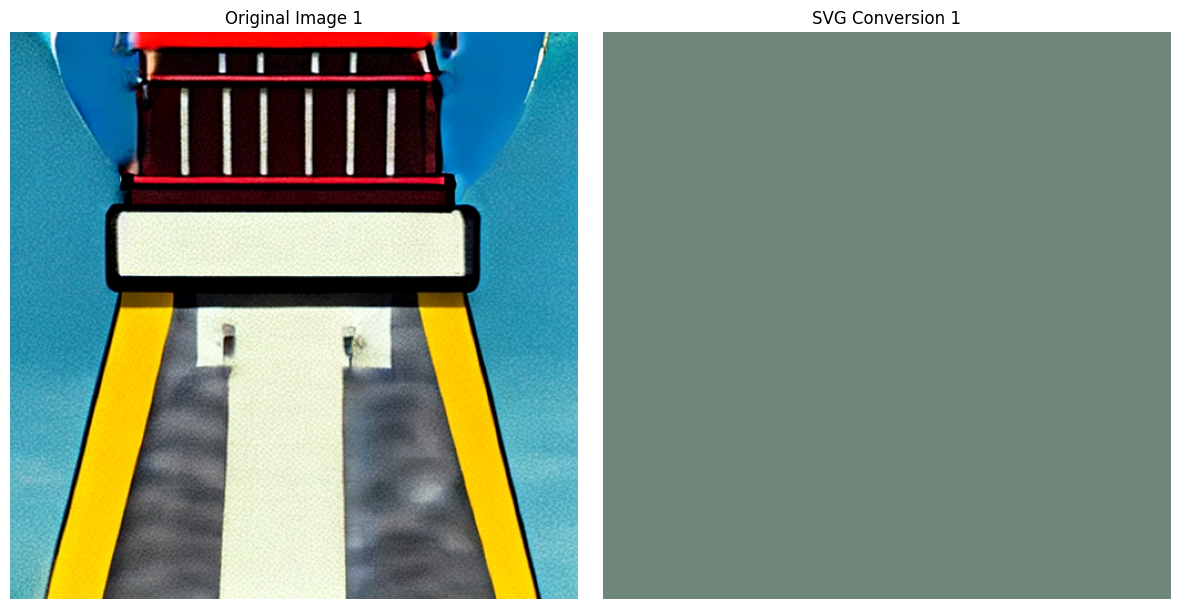

[Attempt 1] SVG evaluation failed: name 'evaluate_with_competition_metric' is not defined

=== Generation Attempt 2/3 ===


Traceback (most recent call last):
  File "/tmp/ipykernel_131/2375175196.py", line 147, in generate_and_convert_advanced
    svg_scores = evaluate_with_competition_metric(svg_content, description)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'evaluate_with_competition_metric' is not defined


  0%|          | 0/15 [00:00<?, ?it/s]

Bitmap generation: 8.84s
SVG conversion: 4.39s (size 18655 bytes)


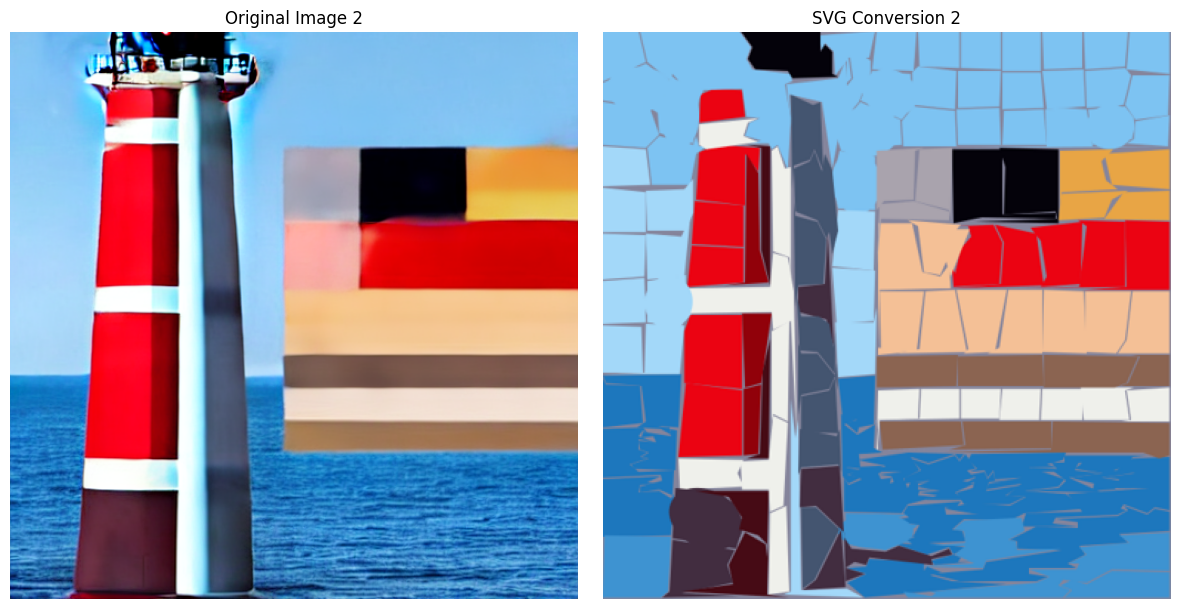

[Attempt 2] SVG evaluation failed: name 'evaluate_with_competition_metric' is not defined

=== Generation Attempt 3/3 ===


Traceback (most recent call last):
  File "/tmp/ipykernel_131/2375175196.py", line 147, in generate_and_convert_advanced
    svg_scores = evaluate_with_competition_metric(svg_content, description)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'evaluate_with_competition_metric' is not defined


  0%|          | 0/15 [00:00<?, ?it/s]

Bitmap generation: 8.97s
SVG conversion: 5.74s (size 140 bytes)


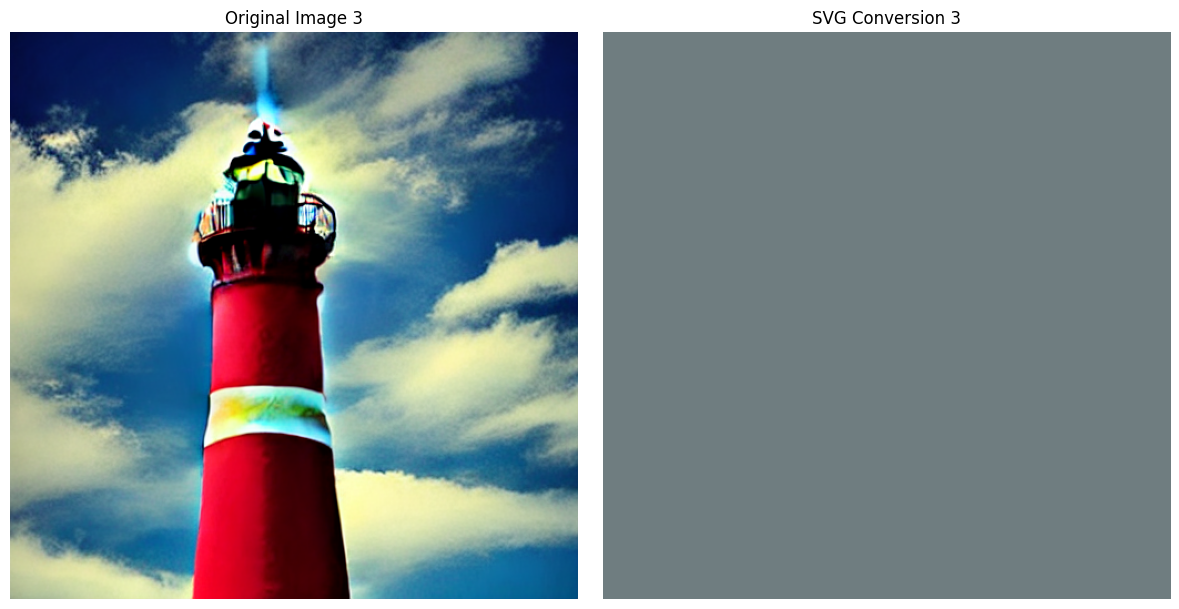

[Attempt 3] SVG evaluation failed: name 'evaluate_with_competition_metric' is not defined

=== Timing Summary ===
Avg generation time: 8.86s
Avg conversion time: 6.04s
Total pipeline time: 46.27s
Best SVG score: -inf


Traceback (most recent call last):
  File "/tmp/ipykernel_131/2375175196.py", line 147, in generate_and_convert_advanced
    svg_scores = evaluate_with_competition_metric(svg_content, description)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'evaluate_with_competition_metric' is not defined


In [19]:
best_svg, best_score, all_attempts = generate_and_convert_advanced(
    prompt_prefix="Close up of",
    description="a lighthouse overlooking the ocean",
    prompt_suffix="flat color blocks, beautiful, minimal details, solid colors only",
    negative_prompt="lines, hatching, textures, patterns, details, outlines",
    num_inference_steps=15,
    num_attempts=3,
    verbose=True
)